In [1]:
import os
import sys
from decimal import Decimal

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import measure

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from m2py.utils import config
from m2py.utils import pre_processing as pre
from m2py.utils import post_processing as post
from m2py.utils import seg_label_utils as slu
from m2py.segmentation import segmentation_gmm as seg_gmm
from m2py.segmentation import segmentation_watershed as seg_water

# Data intake and label generation

In [2]:
lit_files = '/Users/wesleytatum/Dropbox/SSTS_files/Manuscript/data_files/'

im1_opv = np.load(lit_files+'175C_30min_Sub8_Dev8.npy')
im3_annealed = np.load(lit_files+'P3HT-PCBM_150C_15min_sub2.npy')
im5_PTB7 = np.load(lit_files+'PTB7PC71BM_CBonly_ascast_fresh_500 nm_combined.npy')
im6_OFET = np.load(lit_files+'150C_30min_8_3_combined.npy')
im7_NWs = np.load(lit_files+'100-0_72_NW_combined.npy')
cafm = np.load(lit_files+'WT2-97_cafm.npy')
amfm = np.load(lit_files+'WT2-107_amfm_90.npy')

ims = [im1_opv, im3_annealed, im5_PTB7, im6_OFET, im7_NWs, cafm, amfm]

In [3]:
def m2py_pipeline(dataframe, heightless, outlier_threshold, n_components, padding, embedding_dim, thresh, nonlinear, normalize, zscale, data_type, data_subtype, input_cmap):
    """
    Wrapper function for m2py tools. Allows to include or exclude m2py tools in the order shown in the code.
    
    Args:
    dataframe - np.array(). 3D array of SPM data
    heightless - bool. if 'True', height channel is removed. Height is assumed to be dataframe[:,:,4]
    n_components - int. number specifying the number of Gaussian phase distributions to be identified in dataframe
    padding - int. number specifying the degree of closeness of neighbors to be included in GMM labelling
    embedding_dims - int. number specifying the number of principle components to use in PCA before GMM labelling
    nonlinear - bool. if 'True', nonlinear properties are generated prior to analysis. Includes x^2, x^3, abs(x),
                and 1/x
                
    Returns:
    outliers - np.array(). 2D array of outliers
    seg1_labels - np.array(). 2D array of GMM labels
    seg2_labels - np.array(). 2D array of clustering labels
    """
  
    fill_zeros_flag = True
    remove_outliers_flag = True
    input_cmap = input_cmap
    
    # Apply frequency removal
    data = pre.apply_frequency_removal(dataframe, data_type)
    
    data_properties = config.data_info[data_type]['properties']

    # Extract outliers
    outliers = pre.extract_outliers(data, data_type, threshold = outlier_threshold)
    no_outliers_data = pre.smooth_outliers_from_data(data, outliers)
    
    pre.show_outliers(dataframe, data_type, outliers)

    # Show a-priori distributions
    pre.show_property_distributions(data, data_type, outliers)

    c = data.shape[2]
    num_pca_components = min(embedding_dim, c)
    
    # Run GMM segmentation
    seg1 = seg_gmm.SegmenterGMM(n_components = n_components, embedding_dim = num_pca_components, padding = padding,
                                nonlinear = nonlinear, normalize=normalize, zscale=zscale)

    if heightless == True:
        # Remove height property
        height_id = data_properties.index("Height")
        
        no_height_data = np.delete(no_outliers_data, height_id, axis=2)

        seg1_labels = seg1.fit_transform(no_height_data, outliers)
        
        if fill_zeros_flag:
            seg1_labels = slu.fill_out_zeros(seg1_labels, outliers)

        elif remove_outliers_flag:
            seg1_labels = np.ma.masked_where(outliers == 1, pre_labels)

        post.show_classification(seg1_labels, no_height_data, data_type)
        post.show_classification_correlation(seg1_labels, no_height_data, data_type)
        post.show_distributions_together(seg1_labels, no_height_data, data_type, input_cmap = 'jet')
        post.show_grain_area_distribution(seg1_labels, data_type, data_subtype)

        # Overlay distributions on pixels
        probs = seg1.get_probabilities(no_height_data)
        post.show_overlaid_distribution(probs, no_height_data, data_type)
        
        if embedding_dim != None:
            h, w, c = no_height_data.shape

            pca_components = seg1.get_pca_components(no_height_data)
            pca_components = pca_components.reshape(h, w, num_pca_components)
            post.show_classification_correlation(seg1_labels, pca_components, data_type, title_flag=False)

            post.show_classification_distributions(seg1_labels, pca_components, data_type, title_flag=False)

        else:
            pass
            
#         X = np.ravel(seg1_labels)
#         for i in range(5):
#             Y = np.ravel(no_height_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()

## Persistence Watershed Segmentation clustering
    
        if thresh != None:
        
            seg2 = seg_water.SegmenterWatershed()
            height_id = data_properties.index("Height")
            height_data = data[:, :, height_id]
            thresh = thresh

            seg2_labels = seg2.fit_transform(height_data, outliers, thresh)
                    
    # Instance segmentation (using persistence watershed) combined with gmm segmentation
            seg2_labels[seg1_labels == 1] = np.max(seg2_labels) + 1 # map background label of gmm to next pws label
            for l in np.unique(seg2_labels): # clean up small pws labels
                if np.sum(seg2_labels == l) < 2000:
                    seg2_labels = slu.fill_out_zeros(seg2_labels, seg2_labels == l)

            seg2_labels = slu.get_significant_labels(seg2_labels, bg_contrast_flag=True)
            post.show_classification(seg2_labels, no_height_data, data_type)

## Conected-components clustering
        else:
            post_labels = seg1.get_grains(seg1_labels)
            seg2_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)

        post.show_classification(seg2_labels, no_height_data, data_type, input_cmap = input_cmap)
        post.show_grain_area_distribution(seg2_labels, data_type, data_subtype)
        
#         X = np.ravel(seg2_labels)
#         for i in range(5):
#             Y = np.ravel(no_height_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()

        
    elif heightless == False:
        
        seg1_labels = seg1.fit_transform(no_outliers_data, outliers)
        
        if fill_zeros_flag:
            seg1_labels = slu.fill_out_zeros(seg1_labels, outliers)

        elif remove_outliers_flag:
            seg1_labels = np.ma.masked_where(outliers == 1, pre_labels)

        post.show_classification(seg1_labels, no_outliers_data, data_type)
        post.show_distributions_together(seg1_labels, no_outliers_data, data_type, input_cmap = input_cmap)

        post.show_classification(seg1_labels, no_outliers_data, data_type)
        post.show_classification_correlation(seg1_labels, no_outliers_data, data_type)
        post.show_distributions_together(seg1_labels, no_outliers_data, data_type, input_cmap = input_cmap)

        # Overlay distributions on pixels
        probs = seg1.get_probabilities(no_outliers_data)
        post.show_overlaid_distribution(probs, no_outliers_data, data_type)
        post.show_grain_area_distribution(seg1_labels, data_type, data_subtype)
        
        
        if embedding_dim != None:
            h, w, c = no_outliers_data.shape

            pca_components = seg1.get_pca_components(no_outliers_data)
            pca_components = pca_components.reshape(h, w, num_pca_components)
            post.show_classification_correlation(seg1_labels, pca_components, data_type, title_flag=False)

            post.show_classification_distributions(seg1_labels, pca_components, data_type, title_flag=False)

            
        else:
            pass
            
#         X = np.ravel(seg1_labels)
#         for i in range(6):
#             Y = np.ravel(no_outliers_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()
        
## Persistence Watershed Segmentation clustering
    
        if thresh != None:
        
            seg2 = seg_water.SegmenterWatershed()
            height_id = data_properties.index("Height")
            height_data = data[:, :, height_id]
            thresh = thresh

            seg2_labels = seg2.fit_transform(height_data, outliers, thresh)
            
    # Instance segmentation (using persistence watershed) combined with gmm segmentation
            seg2_labels[seg1_labels == 1] = np.max(seg2_labels) + 1 # map background label of gmm to next pws label
            for l in np.unique(seg2_labels): # clean up small pws labels
                if np.sum(seg2_labels == l) < 2000:
                    seg2_labels = slu.fill_out_zeros(seg2_labels, seg2_labels == l)

            seg2_labels = slu.get_significant_labels(seg2_labels, bg_contrast_flag=True)
            post.show_classification(seg2_labels, no_outliers_data, data_type)

## Conected-components clustering
        else:
            post_labels = seg1.get_grains(seg1_labels)
            seg2_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)
        
        post.show_classification(seg2_labels, no_outliers_data, data_type, input_cmap = input_cmap)
        post.show_grain_area_distribution(seg2_labels, data_type, data_subtype)

#         X = np.ravel(seg2_labels)
#         for i in range(6):
#             Y = np.ravel(no_outliers_data[:,:,i])
#             plt.scatter(X, Y, s = 50, marker = 'o', color = 'r', alpha = 0.1)
#             plt.ticklabel_format(style = 'sci')
#             plt.ylim((Y.min()-Y.min()*0.5), (Y.max()+Y.max()*0.1))
#             plt.show()
        
    else:
        print ('Error: Heightless flag incorrect')
    
    return outliers, seg1_labels, seg2_labels

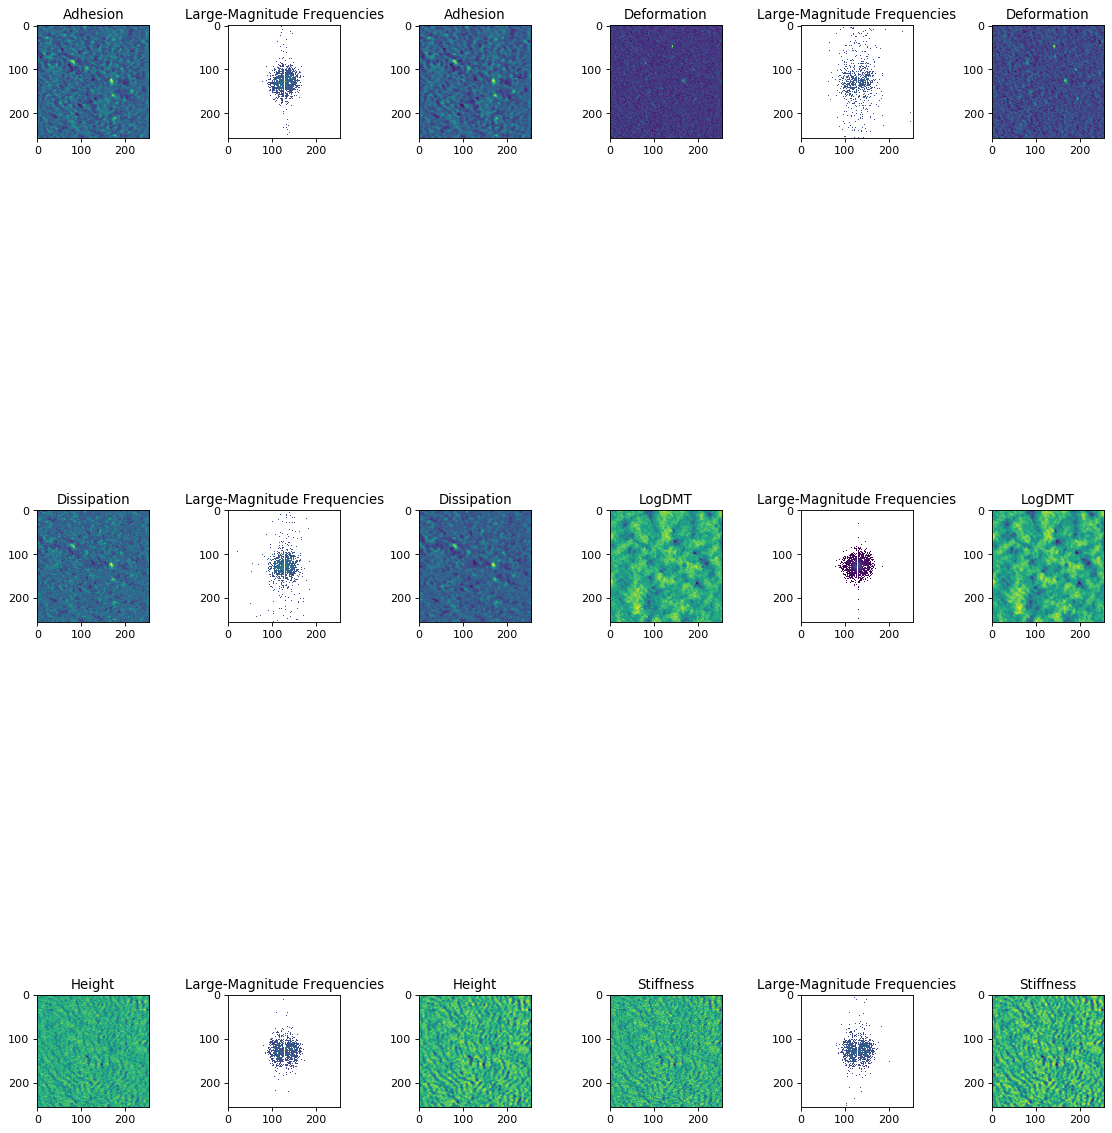

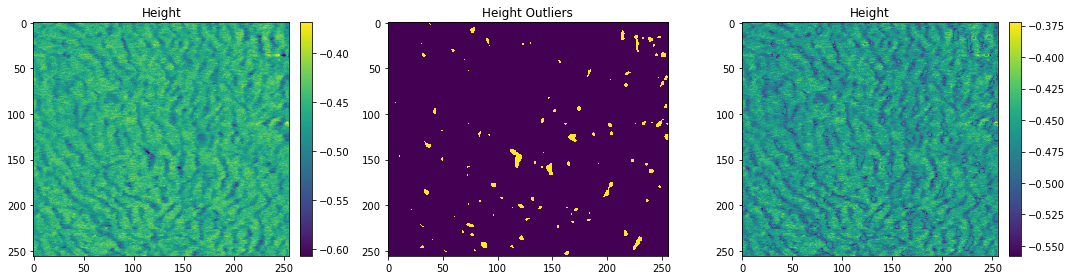

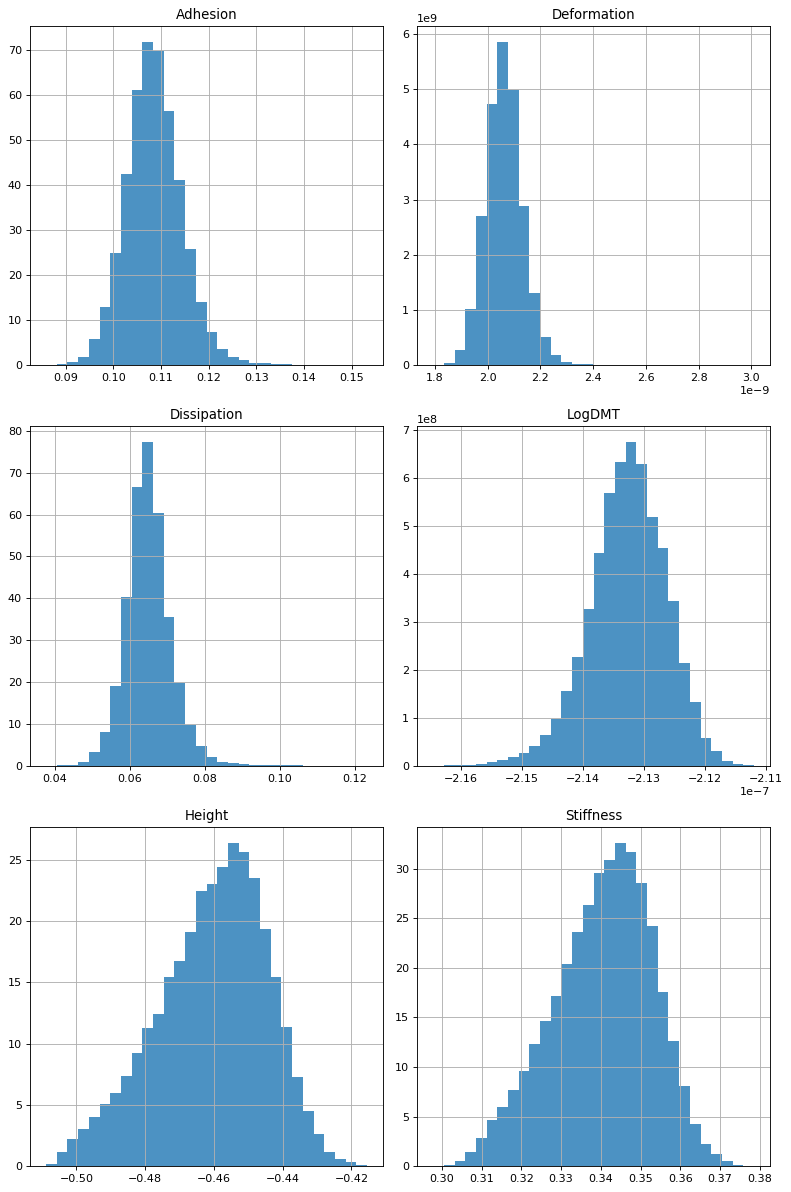

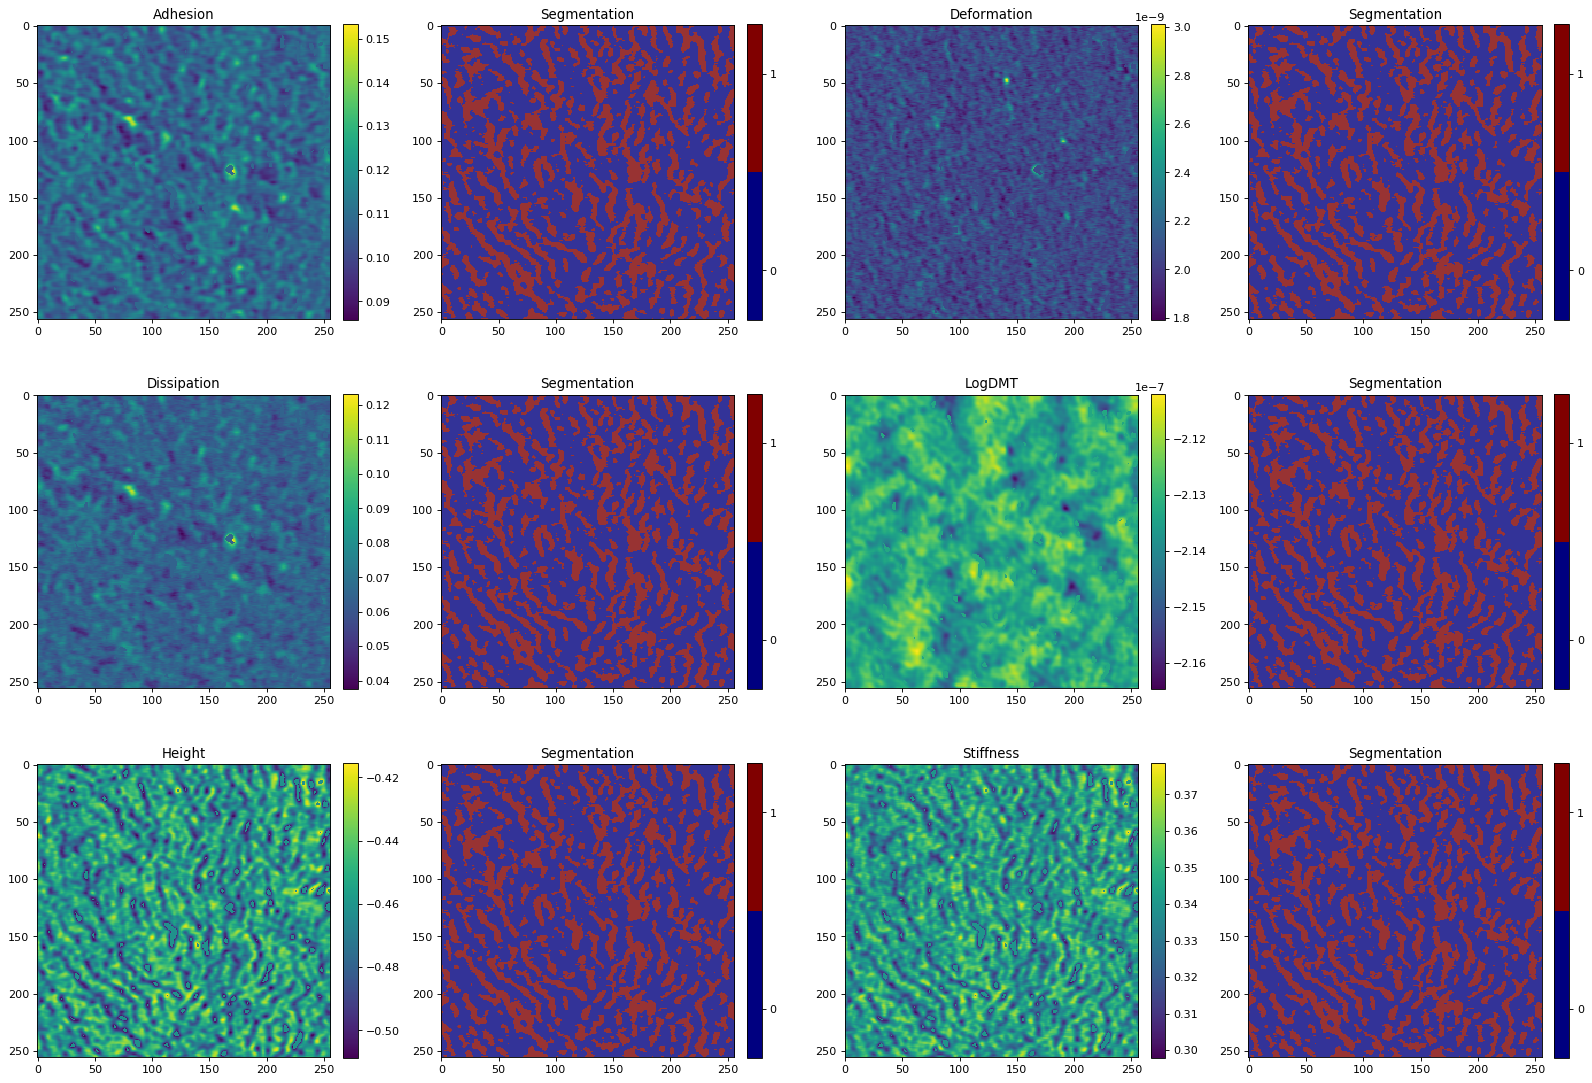

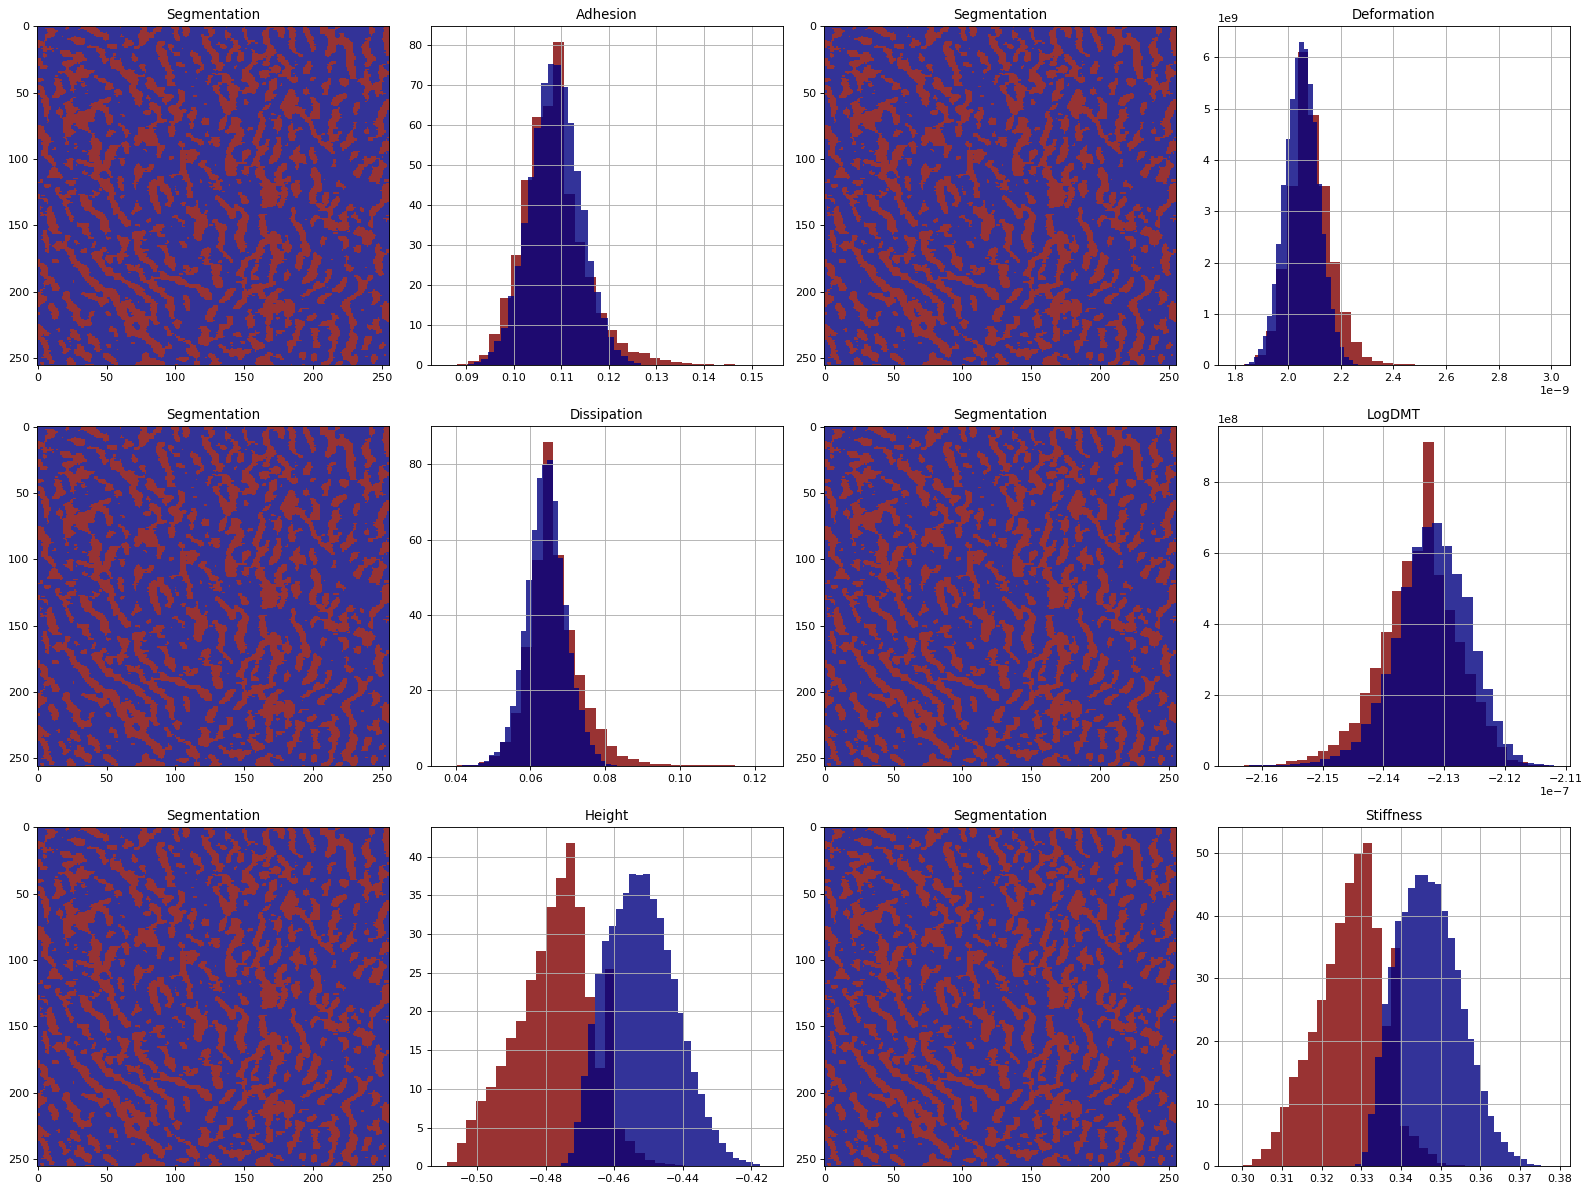

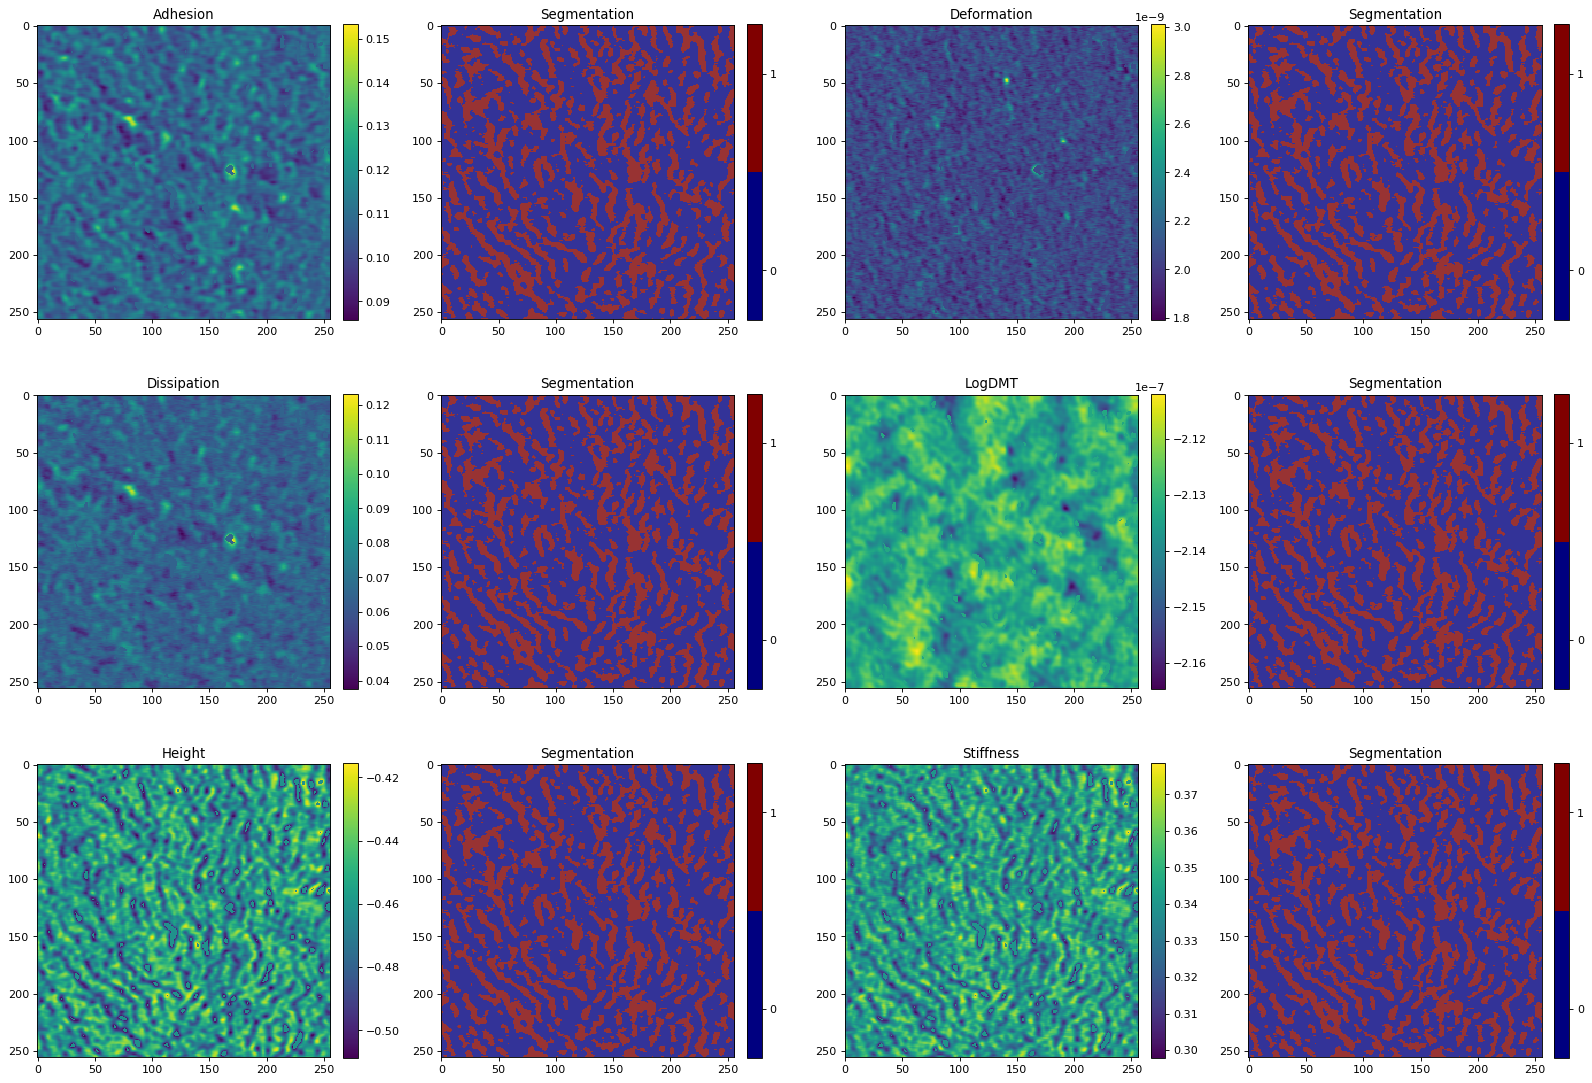

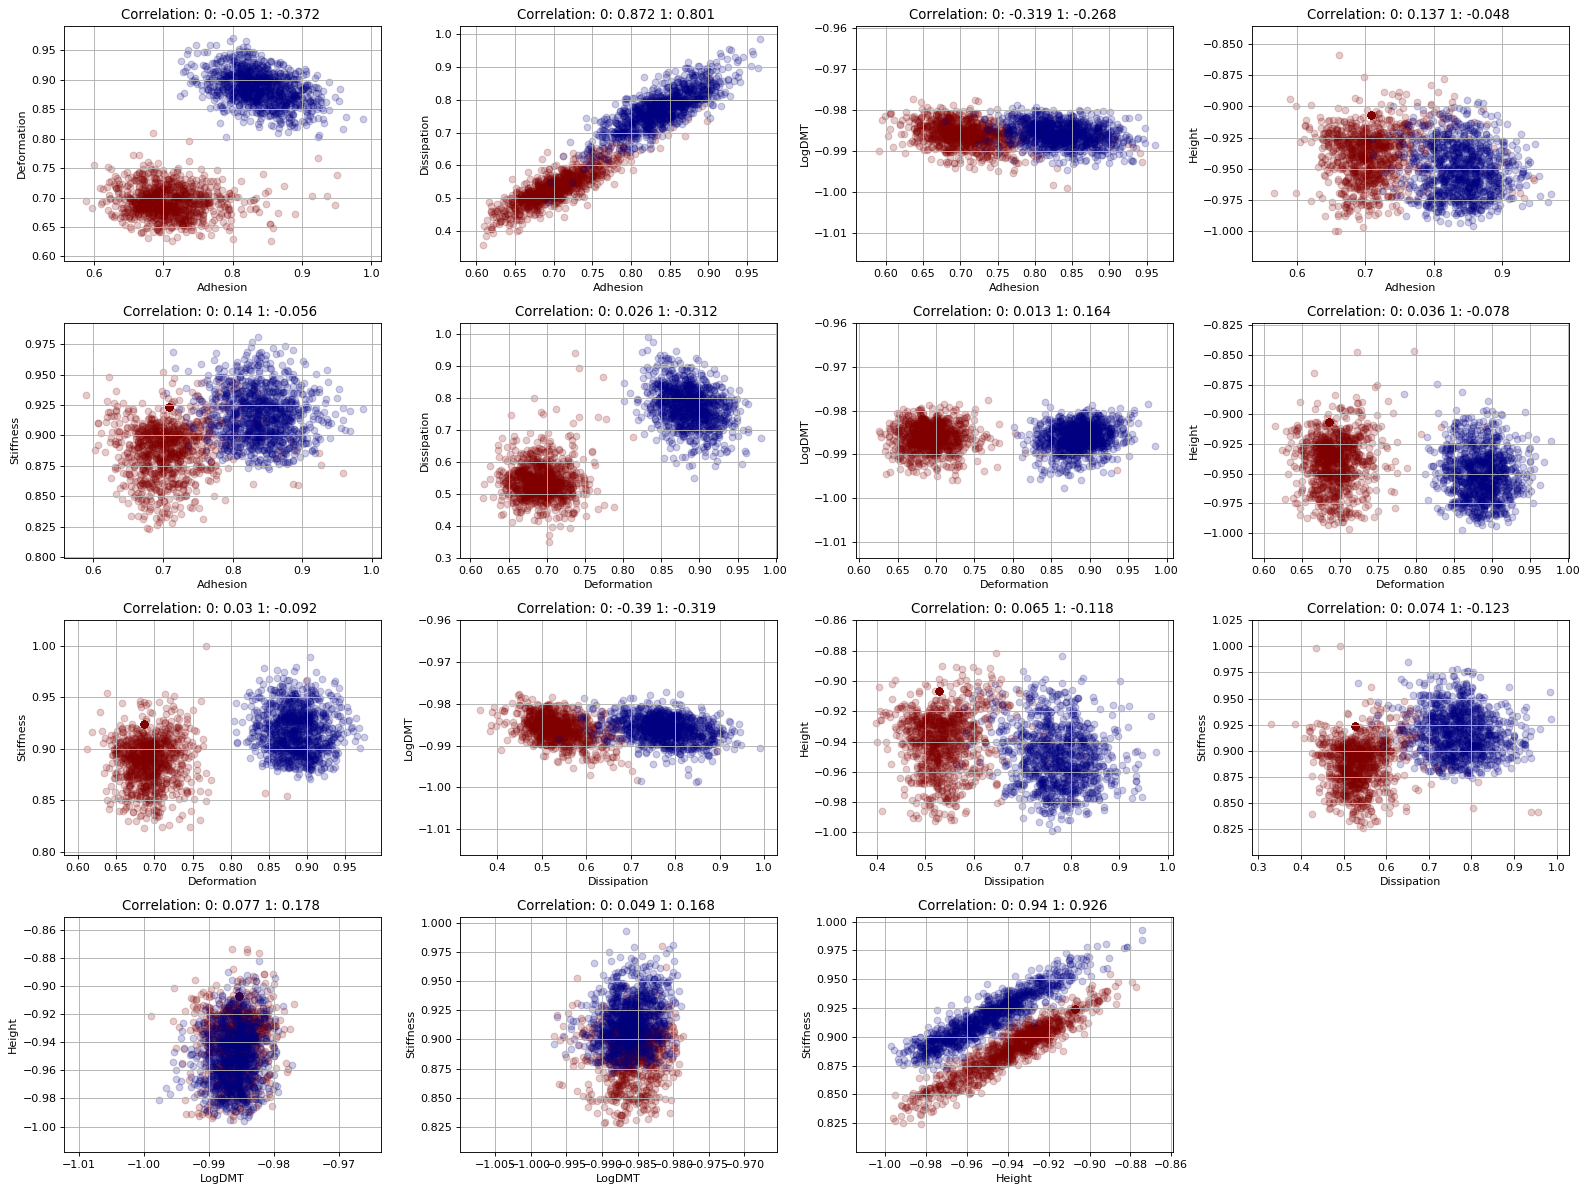

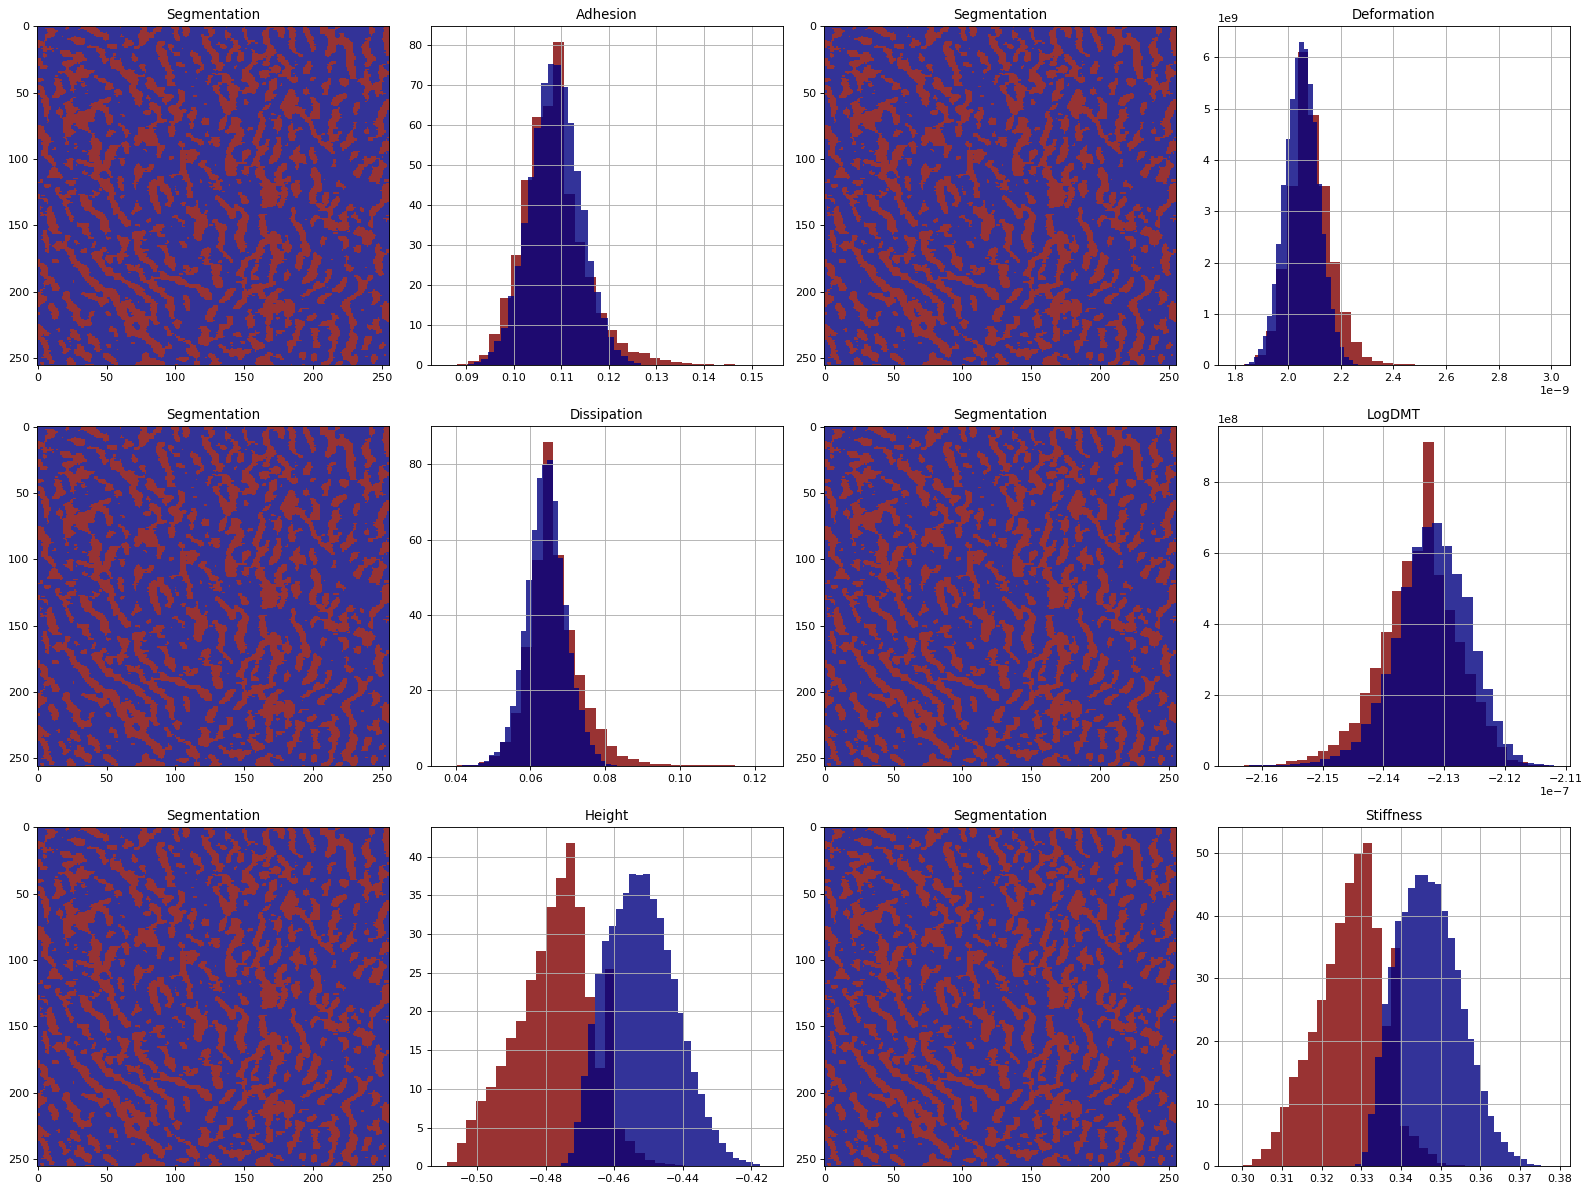

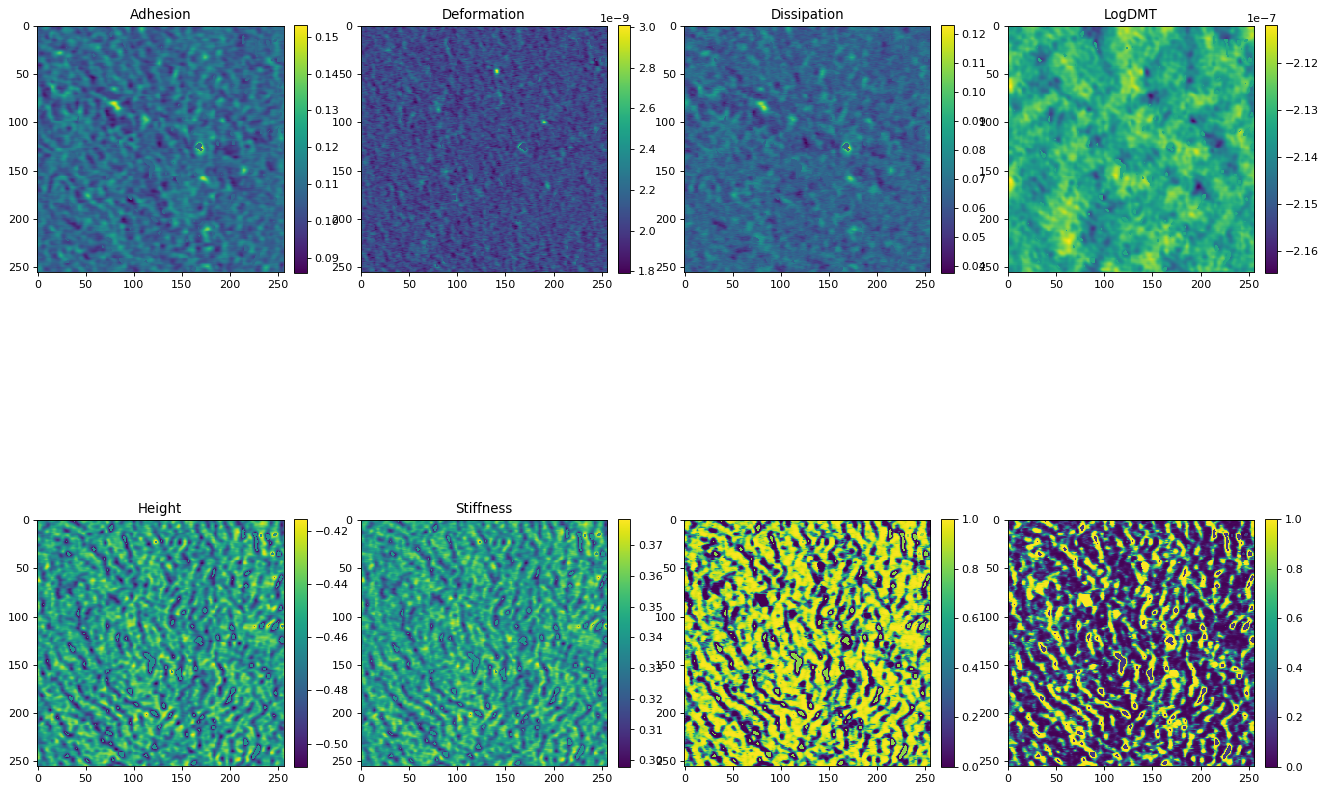

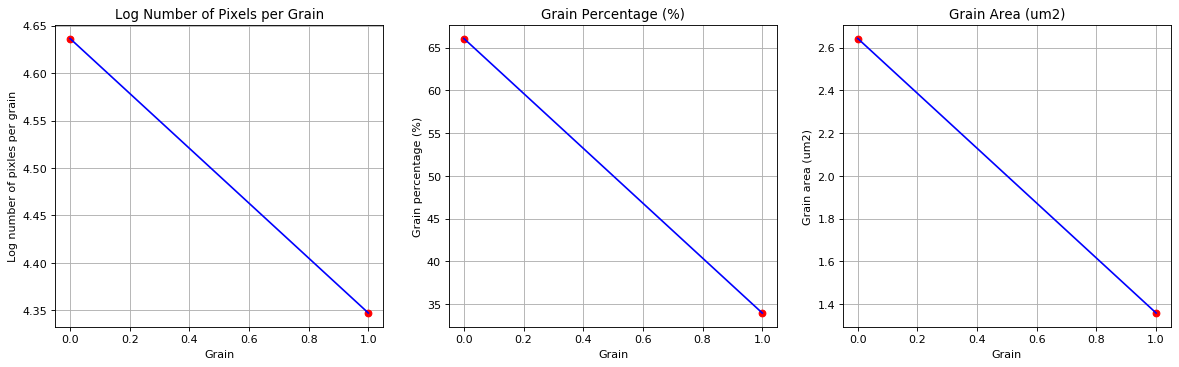

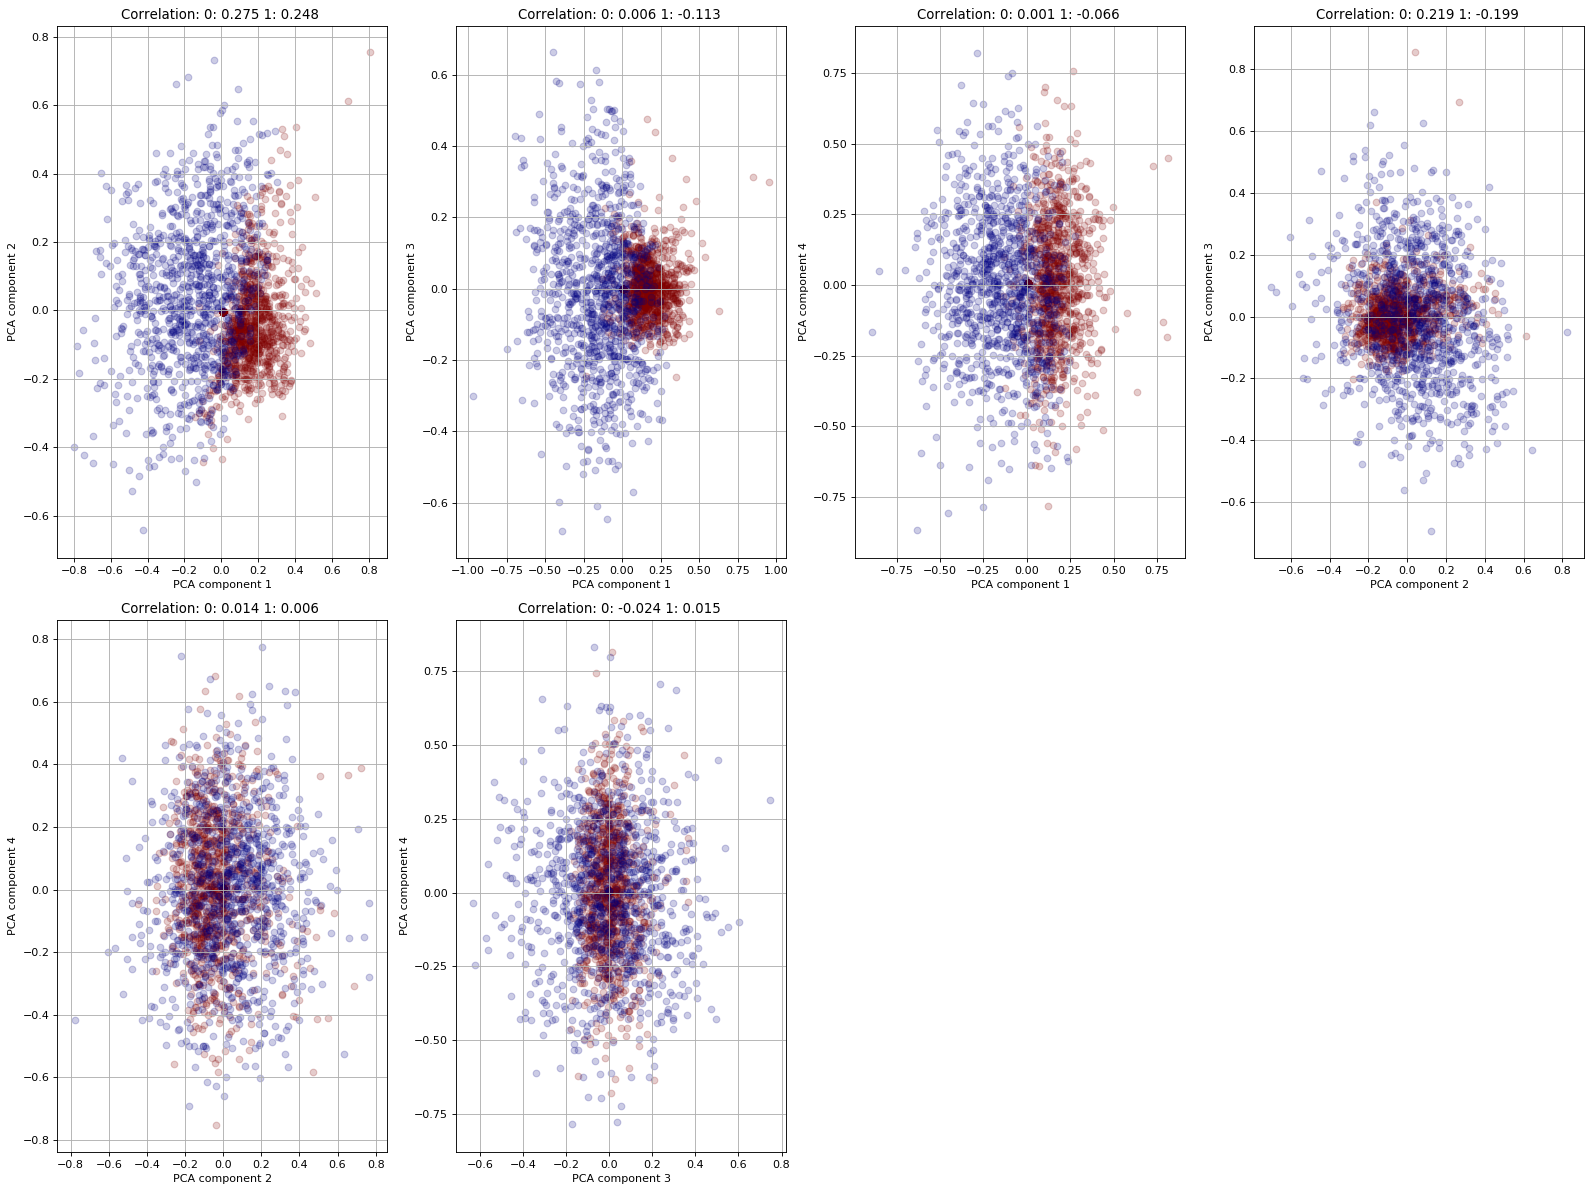

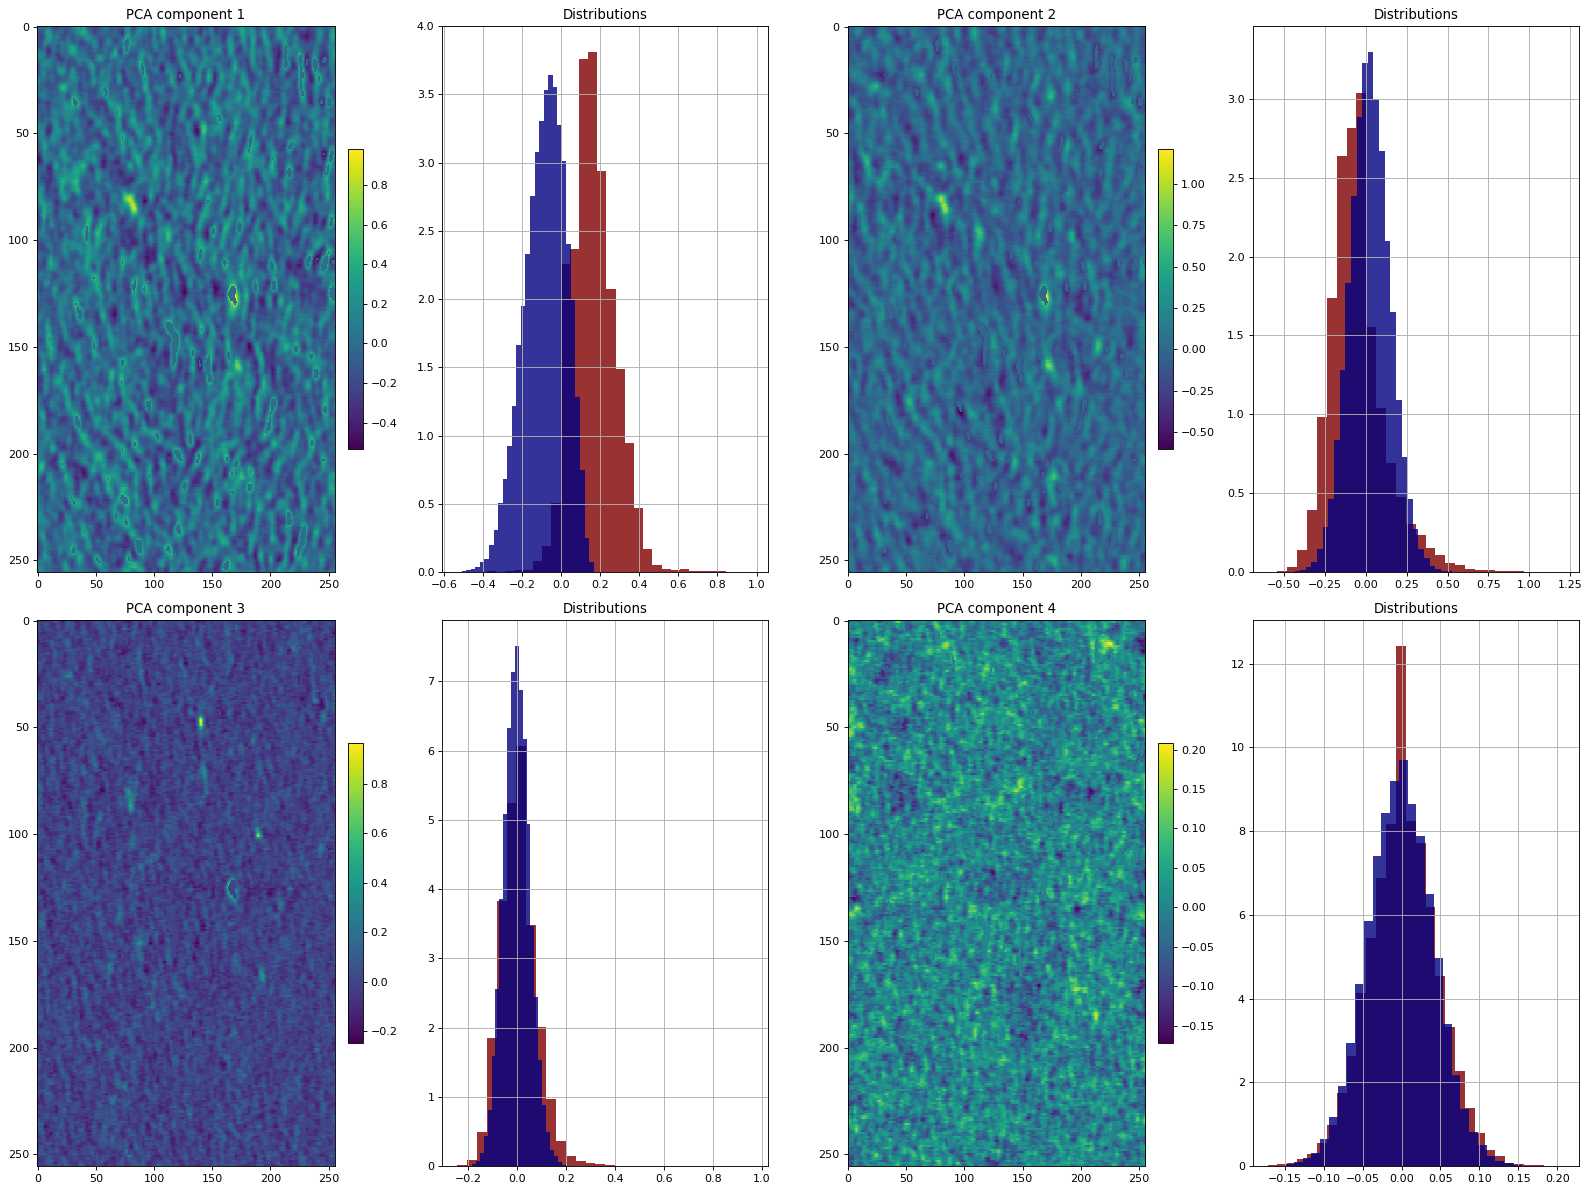

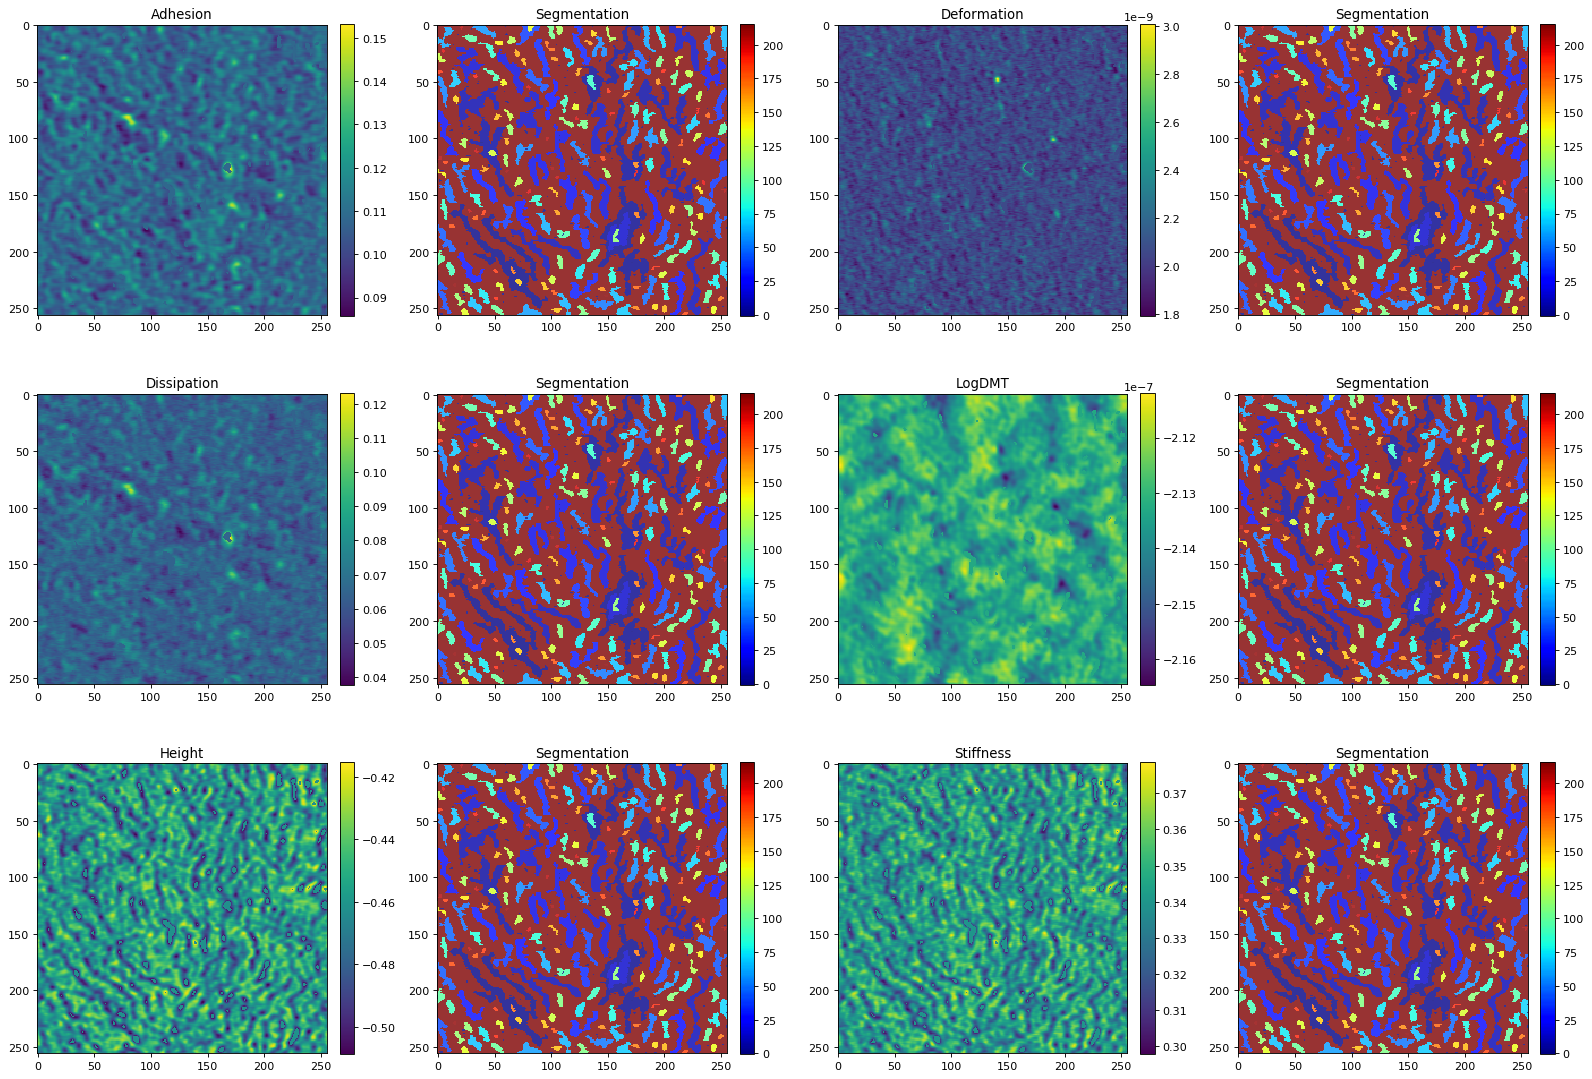

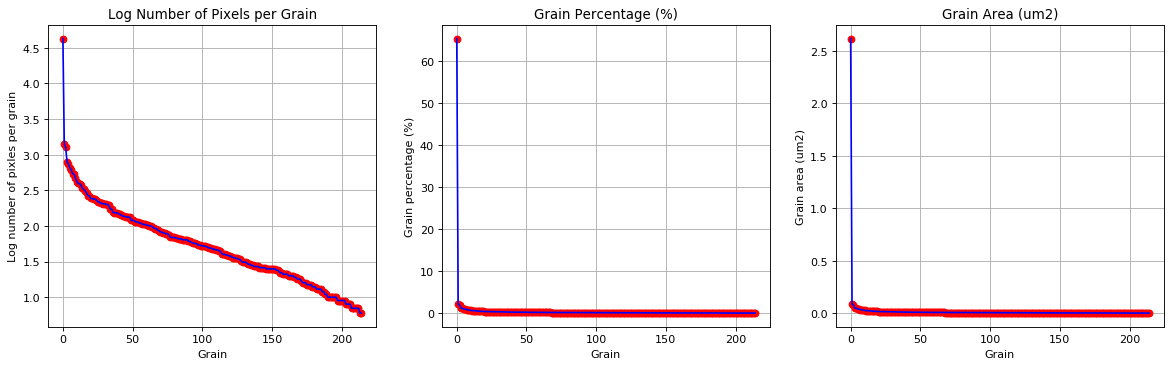

-----------0---------------------------------
--------------------0------------------------
-----------------------------0---------------


In [12]:
# ims = [im1_opv, im3_annealed, im5_PTB7, im6_OFET, im7_NWs, cafm, amfm]
ims = [im1_opv]
n_components = [2]
heightless = [False]
outlier_threshold = [2.5]
padding = 0
embedding_dim = 4
thresh = None     ## Persistence Watershed Threshold
nonlinear = True
normalize = True
zscale = False
data_type = ['QNM']
data_subtype = ['Backgrounded']
input_cmap = ['jet']

seg1_dict = {}    
seg2_dict = {}

p_stats = {}
g_stats = {}

phases = {}
grains = {}
correlated_labels = {}

h = 0
for h, im in enumerate(ims):
    outliers, seg1_labels, seg2_labels = m2py_pipeline(im, heightless = heightless[h],
                                                          n_components = n_components[h],
                                                          outlier_threshold = outlier_threshold[h],
                                                          padding = padding,
                                                          embedding_dim = embedding_dim,
                                                          thresh = thresh,
                                                          nonlinear = nonlinear,
                                                          normalize = normalize,
                                                          zscale = zscale,
                                                          data_type = data_type[h],
                                                          data_subtype = data_subtype[h],
                                                          input_cmap = input_cmap[h])
    
    print (f'-----------{h}---------------------------------')
    print (f'--------------------{h}------------------------')
    print (f'-----------------------------{h}---------------')
    
    seg1_dict[h] = seg1_labels
    seg2_dict[h] = seg2_labels
    
#     p_stats[h] = get_stats_dict(seg1_labels, im)
#     g_stats[h] = get_stats_dict(seg2_labels, im)
    
#     phases[h] = slu.phase_sort(im, seg1_labels, n_components)
#     grains[h] = slu.grain_sort(im, seg2_labels)
    
#     correlated_labels[h] = label_comparison(seg1_labels, seg2_labels)

# Extract semantic and instance segmentation labels

In [13]:
phase_labels = seg1_labels
grain_labels = seg2_labels

x,y = phase_labels.shape
print (x,y)

256 256


# Compare pixel count for 2 phases

In [14]:
phase1 = np.asarray([label for label in phase_labels == 1])
phase2 = np.asarray([label for label in phase_labels == 2])

In [15]:
phase1_count = 0
phase2_count = 0

for i in range(x):
    for j in range(y):
        if phase1[i,j] == True:
            phase1_count+=1
        elif phase2[i,j] == True:
            phase2_count+=1
        else:
            pass

In [16]:
print (phase1_count, phase2_count)
print ('phase1 = ', phase1_count/(phase1_count+phase2_count), ' %')
print ('phase2 = ', phase2_count/(phase1_count+phase2_count), ' %')

43289 22247
phase1 =  0.6605377197265625  %
phase2 =  0.3394622802734375  %


# Access pixels for a single arbitrary grain

In [17]:
grain_count = grain_labels.max()

print (grain_count)

216.0


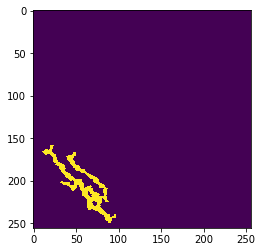

In [20]:
grain = np.asarray([label for label in grain_labels == 2])
grain = grain.astype(int)
# print (grain)
plt.imshow(grain)

In [21]:
def resize_boundaries(grain):
    
    x,y = grain.shape
    left_edge = y
    right_edge = 0
    top_edge = x
    bottom_edge = 0
    
    for i in range(x):
        for j in range(y):
            if grain[i,j] == True:
                if j < left_edge:
                    left_edge = j
                elif j > right_edge:
                    right_edge = j
                else:
                    pass

                if i < top_edge:
                    top_edge = i
                elif i > bottom_edge:
                    bottom_edge = i
                else:
                    pass

            else:
                pass
            
    if left_edge == 0:
        left_edge = 1
    else:
        pass
    if right_edge == y:
        right_edge = y-1
    else:
        pass
    if top_edge == 0:
        top_edge = 1
    else:
        pass
    if bottom_edge == x:
        bottom_edge = x-1
    else:
        pass
            
#     print (left_edge, right_edge, top_edge, bottom_edge)

    return np.asarray(grain[(top_edge-1):(bottom_edge+2), (left_edge-1):(right_edge+2)])

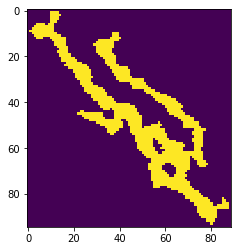

In [22]:
resized_grain = resize_boundaries(grain)
# print (resized_grain.shape)
plt.imshow(resized_grain)

In [23]:
def all_domain_properties(grain_labels):
    
    all_props = {}
    
    grain_count = int(grain_labels.max())
    
    for i in range(2, grain_count+1):
#         print (i)
    
        grain = np.asarray([label for label in grain_labels == i])
        grain = grain.astype(int)
        resized_grain = resize_boundaries(grain)
        props_table = measure.regionprops_table(resized_grain, properties = ['label', 'major_axis_length','minor_axis_length',
                                                                             'eccentricity', 'orientation', 'perimeter'])
        props_table['label'] = i
    
        all_props[i] = props_table
        
    props_df = pd.DataFrame.from_dict(all_props, orient = 'index')
    
    return props_df

In [24]:
test = all_domain_properties(grain_labels)

In [25]:
print (test)

     label     major_axis_length     minor_axis_length           eccentricity  \
2        2  [115.63377753394506]  [32.671008830424455]   [0.9592559219559058]   
3        3   [93.86812041060148]  [40.481729707468574]    [0.902226858694186]   
4        4   [93.99734120480426]  [25.140377243536552]   [0.9635694117822104]   
5        5   [75.38519872005651]   [26.25329416738124]   [0.9373997299317319]   
6        6   [73.94830312059806]   [22.86261020006099]   [0.9510067295688757]   
7        7   [63.69758924220352]  [28.055038833842886]    [0.897781489015623]   
8        8  [54.968063560844406]  [25.396589078230406]   [0.8868671895533692]   
9        9    [45.1722982701708]  [25.124859426866298]   [0.8310480683623358]   
10      10   [66.87238539194679]  [30.036126545034776]   [0.8934533989879064]   
11      11   [85.25263325597683]  [15.998507484849162]   [0.9822340514158241]   
12      12  [47.863848394298515]   [18.29686388186462]   [0.9240511007927191]   
13      13   [50.42664661870

In [34]:
def plot_descriptors(descriptor_dict):

    fig = plt.figure(figsize = (12,8))

    ax = fig.add_subplot(2,3,1)
    plt.scatter(descriptor_dict['label'], descriptor_dict['major_axis_length'])
    ax.set_title('major_axis_length')

    ax = fig.add_subplot(2,3,2)
    plt.scatter(descriptor_dict['label'], descriptor_dict['minor_axis_length'])
    ax.set_title('minor_axis_length')

    ax = fig.add_subplot(2,3,3)
    plt.scatter(descriptor_dict['label'], descriptor_dict['perimeter'])
    ax.set_title('perimeter')

    ax = fig.add_subplot(2,3,4)
    plt.scatter(descriptor_dict['label'], descriptor_dict['orientation'])
    ax.set_title('orientation')

    ax = fig.add_subplot(2,3,5)
    plt.scatter(descriptor_dict['label'], descriptor_dict['eccentricity'])
    ax.set_title('eccentricity')

    plt.tight_layout()
    plt.show()

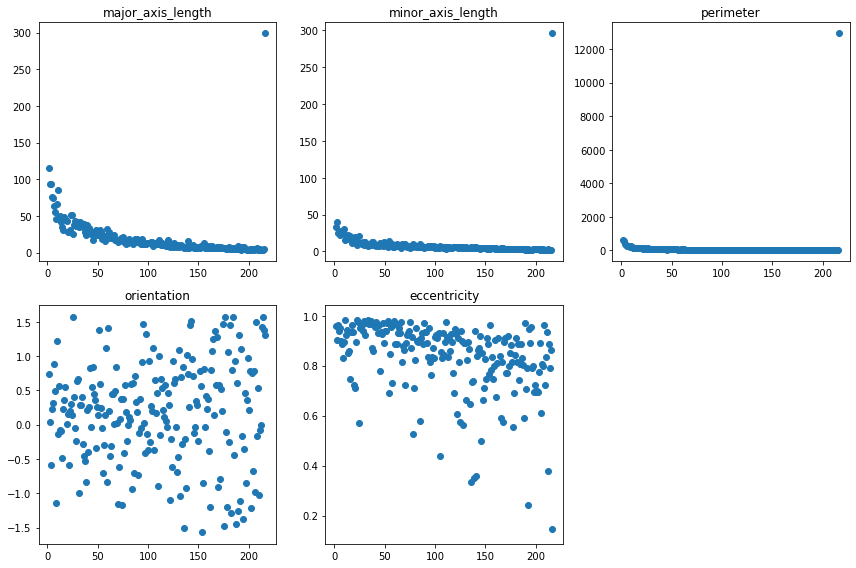

In [35]:
plot_descriptors(test)

In [2]:
map_file_path = '/Volumes/Tatum_SSD-1/Grad_School/m2py/Morphology_labels/OFET_morph_maps/Default_params/'
files = os.listdir(map_file_path)
print (len(files))
print (files)

seg1_fl_list = []
seg2_fl_list = []

seg1_dict = {}
seg2_dict = {}

for fl in files:
    if fl[-5] == '1':
        seg1_fl_list.append(fl)
    elif fl[-5] == '2':
        seg2_fl_list.append(fl)
    else:
        print(fl[-5], ' is messed up')

for k, fl in enumerate(seg1_fl_list):
    seg1_dict[k] = np.load(map_file_path+fl)
    
for k, fl in enumerate(seg2_fl_list):
    seg2_dict[k] = np.load(map_file_path+fl)

74
['100C_10min_3_1_seg1.npy', '100C_10min_3_1_seg2.npy', '100C_10min_3_3_seg1.npy', '100C_10min_3_3_seg2.npy', '100C_10min_3_5-1_seg1.npy', '100C_10min_3_5-1_seg2.npy', '100C_10min_3_5_seg1.npy', '100C_10min_3_5_seg2.npy', '100C_10min_4_3_seg1.npy', '100C_10min_4_3_seg2.npy', '100C_15min_6_4-1_seg1.npy', '100C_15min_6_4-1_seg2.npy', '100C_15min_6_5_seg1.npy', '100C_15min_6_5_seg2.npy', '100C_30min_8_1_seg1.npy', '100C_30min_8_1_seg2.npy', '100C_30min_8_2_seg1.npy', '100C_30min_8_2_seg2.npy', '100C_30min_8_5_seg1.npy', '100C_30min_8_5_seg2.npy', '100C_5min_2_1_seg1.npy', '100C_5min_2_1_seg2.npy', '100C_5min_2_2_seg1.npy', '100C_5min_2_2_seg2.npy', '125C_10min_3_1_seg1.npy', '125C_10min_3_1_seg2.npy', '125C_10min_4_2_seg1.npy', '125C_10min_4_2_seg2.npy', '125C_10min_4_5_seg1.npy', '125C_10min_4_5_seg2.npy', '125C_15min_5_3_seg1.npy', '125C_15min_5_3_seg2.npy', '125C_15min_5_4_seg1.npy', '125C_15min_5_4_seg2.npy', '125C_15min_6_5_seg1.npy', '125C_15min_6_5_seg2.npy', '125C_30min_7_3_seg1

2156
[1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243

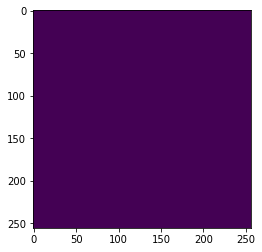

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


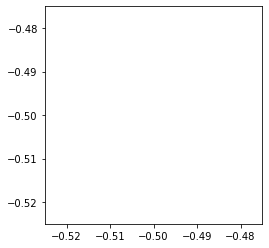

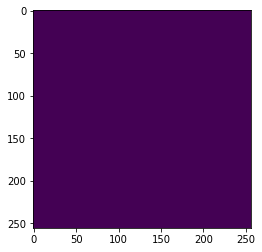

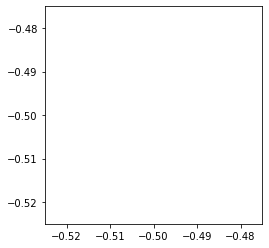

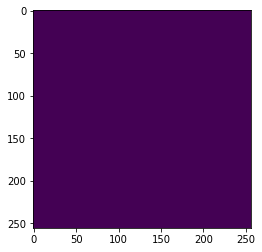

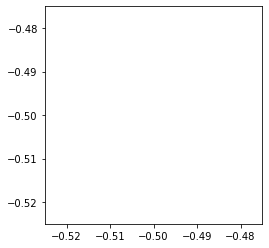

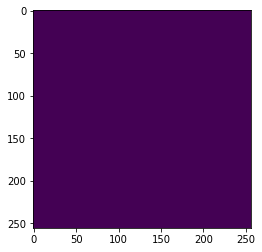

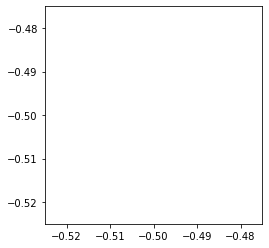

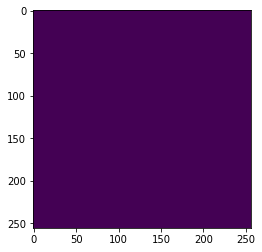

KeyboardInterrupt: 

In [37]:
all_props = {}
domain_labels = seg2_dict[1]
phase_labels = seg1_dict[0]
    
domain_count = int(domain_labels.max())
print (domain_count)

unique_labes = slu.get_unique_labels(domain_labels)
unique_labes.sort()
print (unique_labes)

for i in range(1, domain_count+1):
#         print (i)

    domain = np.asarray([label for label in domain_labels == i])
    #convert bool to int
    domain = domain.astype(int)
    plt.imshow(domain)
    plt.show()

    #Check phase of pixels in the domain
    phase = phase_labels[domain == 1]
    phase_mode, count = stats.mode(phase, axis = None)

    resized_domain = slu.resize_boundaries(domain)
    plt.imshow(resized_domain)
    plt.show()
    
#     _________
#     props_table = measure.regionprops_table(resized_domain, properties = ['label', 'major_axis_length','minor_axis_length',
#                                                                          'eccentricity', 'orientation', 'perimeter'])
#     props_table['label'] = phase_mode[0]

#     #Pass domain stats to proper phase's k:v pair
#     all_props[i] = (props_table)

# props_df = pd.DataFrame.from_dict(all_props, orient = 'index')

In [4]:
test = slu.all_domain_properties(seg1_dict[0], seg2_dict[0])

ValueError: zero-size array to reduction operation maximum which has no identity